In [ ]:
from google.colab import drive
import os

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to your fingerprints folder in Drive
data_path = '/content/drive/MyDrive/Fingerprints'

# List all files
files = os.listdir(data_path)
print("Number of images:", len(files))
print("First 10 files:", files[:10])
print("Last 10 files:", files[::-10])

Number of images: 6000
First 10 files: ['2__F_Right_ring_finger.BMP', '29__F_Right_little_finger.BMP', '29__F_Right_index_finger.BMP', '2__F_Left_thumb_finger.BMP', '29__F_Right_middle_finger.BMP', '2__F_Left_middle_finger.BMP', '29__F_Right_thumb_finger.BMP', '2__F_Left_index_finger.BMP', '2__F_Left_little_finger.BMP', '2__F_Right_little_finger.BMP']
Last 10 files: ['99__M_Right_thumb_finger.BMP', '9__M_Left_middle_finger.BMP', '85__M_Right_thumb_finger.BMP', '88__F_Left_index_finger.BMP', '86__M_Right_little_finger.BMP', '89__M_Right_thumb_finger.BMP', '8__M_Left_little_finger.BMP', '90__M_Left_ring_finger.BMP', '93__M_Left_ring_finger.BMP', '96__M_Right_thumb_finger.BMP', '90__M_Left_middle_finger.BMP', '92__F_Right_little_finger.BMP', '98__M_Right_index_finger.BMP', '94__M_Right_ring_finger.BMP', '95__M_Left_middle_finger.BMP', '97__M_Left_middle_finger.BMP', '97__M_Left_little_finger.BMP', '73__M_Right_thumb_finger.BMP', '76__F_Left_thumb_finger.BMP', '76__F_Right_index_finger.BMP

In [ ]:


records = []

for f in files:
    f_clean = f.strip()  # remove whitespace/newlines
    if not f_clean.lower().endswith(".bmp"):
        continue

    try:
        # Step 1: split by double underscore
        parts = f_clean.split("__")
        if len(parts) != 2:
            print("Skipping unexpected file:", f_clean)
            continue

        person_id = int(parts[0])
        rest = parts[1]  # e.g., 'F_Right_ring_finger.BMP'

        # Step 2: split rest by single underscore
        rest_parts = rest.split("_")
        gender = rest_parts[0].upper()  # F or M
        finger = "_".join(rest_parts[1:-1])  # combine everything except last part '.BMP'
        # finger name: 'Right_ring' etc.

        records.append([f_clean, person_id, gender, finger])

    except Exception as e:
        print("Error parsing file:", f_clean, e)
        continue

df = pd.DataFrame(records, columns=["filename", "person_id", "gender", "finger"])
print(df.head())
print("Total samples:", len(df))
print("Unique persons:", df.person_id.nunique())
print("Gender distribution:\n", df.gender.value_counts())
print("Finger types:\n", df.finger.value_counts())


                        filename  person_id gender        finger
0     2__F_Right_ring_finger.BMP          2      F    Right_ring
1  29__F_Right_little_finger.BMP         29      F  Right_little
2   29__F_Right_index_finger.BMP         29      F   Right_index
3     2__F_Left_thumb_finger.BMP          2      F    Left_thumb
4  29__F_Right_middle_finger.BMP         29      F  Right_middle
Total samples: 6000
Unique persons: 600
Gender distribution:
 gender
M    4770
F    1230
Name: count, dtype: int64
Finger types:
 finger
Right_ring      600
Right_little    600
Right_index     600
Left_thumb      600
Right_middle    600
Left_middle     600
Right_thumb     600
Left_index      600
Left_little     600
Left_ring       600
Name: count, dtype: int64


In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

# ---------------- Transform: Resize all images to 112x112 ----------------
transform = transforms.Compose([
    transforms.Resize((112, 112)),  # ensures uniform size
    transforms.ToTensor(),           # convert to tensor [C,H,W]
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1,1]
])

# ---------------- Finger mapping ----------------
fingers = [
    "Left_thumb", "Left_index", "Left_middle", "Left_ring", "Left_little",
    "Right_thumb", "Right_index", "Right_middle", "Right_ring", "Right_little"
]
finger2idx = {f: i for i, f in enumerate(fingers)}

# ---------------- Custom Dataset ----------------
class FingerprintDataset(Dataset):
    def __init__(self, df, data_path, transform=None):
        self.df = df
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_path, row['filename'])
        image = Image.open(img_path).convert('L')  # grayscale

        if self.transform:
            image = self.transform(image)

        finger_label = finger2idx[row['finger']]
        return image, finger_label

# ---------------- Load Dataset ----------------
data_path = '/content/drive/MyDrive/Fingerprints'  # your folder path
dataset = FingerprintDataset(df, data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# ---------------- Test batch ----------------
images, labels = next(iter(dataloader))
print("Batch image shape:", images.shape)  # torch.Size([32,1,112,112])
print("Batch labels:", labels[:10])


Batch image shape: torch.Size([32, 1, 112, 112])
Batch labels: tensor([4, 4, 6, 8, 8, 4, 2, 9, 1, 6])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- CNN Model ----------------
class FingerCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(FingerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = None  # will define dynamically
        self.fc2 = None

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        # Dynamic flattening
        if self.fc1 is None:
            self._to_linear = x[0].numel()
            self.fc1 = nn.Linear(self._to_linear, 256).to(x.device)
            self.fc2 = nn.Linear(256, 10).to(x.device)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------- Load model and move batch ----------------
model = FingerCNN().to(device)
images, labels = next(iter(dataloader))
images = images.to(device)
labels = labels.to(device)

# ---------------- Forward pass ----------------
outputs = model(images)
print("CNN output shape (before softmax):", outputs.shape)  # should be [32,10]
print("Sample outputs for first 5 images:\n", outputs[:5])


CNN output shape (before softmax): torch.Size([32, 10])
Sample outputs for first 5 images:
 tensor([[ 0.0658,  0.0672,  0.0556,  0.0377,  0.0102,  0.0680, -0.0326, -0.0666,
          0.0784, -0.0716],
        [ 0.0739,  0.0711,  0.0508,  0.0308,  0.0200,  0.0635, -0.0265, -0.0593,
          0.0711, -0.0732],
        [ 0.0585,  0.0697,  0.0570,  0.0385,  0.0157,  0.0584, -0.0178, -0.0644,
          0.0800, -0.0647],
        [ 0.0724,  0.0823,  0.0468,  0.0362,  0.0037,  0.0699, -0.0207, -0.0606,
          0.0818, -0.0781],
        [ 0.0659,  0.0876,  0.0549,  0.0271,  0.0231,  0.0573, -0.0303, -0.0617,
          0.0703, -0.0712]], device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# ---------------- Transform for full dataset ----------------
transform_full = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ---------------- Dataset ----------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['finger'])
train_dataset = FingerprintDataset(train_df, data_path, transform=transform_full)
test_dataset = FingerprintDataset(test_df, data_path, transform=transform_full)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ---------------- CNN Model ----------------
class FingerCNN(nn.Module):
    def __init__(self, num_classes=10, img_size=(112,112)):
        super(FingerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Compute flattened size with dummy input
        dummy = torch.zeros(1,1,*img_size)
        x = self.pool(F.relu(self.conv1(dummy)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        self.flattened_size = x.numel()

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ---------------- Device, Loss, Optimizer ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FingerCNN(num_classes=10, img_size=(112,112)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ---------------- Training Loop ----------------
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % 8 == 0:  # print every 8 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, Acc: {correct/total:.4f}")

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"--> Epoch {epoch+1} Completed: Avg Loss: {epoch_loss:.4f}, Avg Acc: {epoch_acc:.4f}\n")

# ---------------- Evaluation on Test Set ----------------
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")


Epoch [1/5], Batch [8/150], Loss: 2.2816, Acc: 0.1211
Epoch [1/5], Batch [16/150], Loss: 2.1961, Acc: 0.1328
Epoch [1/5], Batch [24/150], Loss: 2.1703, Acc: 0.1289
Epoch [1/5], Batch [32/150], Loss: 1.9915, Acc: 0.1699
Epoch [1/5], Batch [40/150], Loss: 1.9995, Acc: 0.1891
Epoch [1/5], Batch [48/150], Loss: 1.5917, Acc: 0.2142
Epoch [1/5], Batch [56/150], Loss: 1.5686, Acc: 0.2321
Epoch [1/5], Batch [64/150], Loss: 1.6506, Acc: 0.2480
Epoch [1/5], Batch [72/150], Loss: 1.3939, Acc: 0.2669
Epoch [1/5], Batch [80/150], Loss: 1.5956, Acc: 0.2785
Epoch [1/5], Batch [88/150], Loss: 1.5809, Acc: 0.2930
Epoch [1/5], Batch [96/150], Loss: 1.6169, Acc: 0.3034
Epoch [1/5], Batch [104/150], Loss: 1.5827, Acc: 0.3137
Epoch [1/5], Batch [112/150], Loss: 1.4590, Acc: 0.3231
Epoch [1/5], Batch [120/150], Loss: 1.5972, Acc: 0.3294
Epoch [1/5], Batch [128/150], Loss: 1.6099, Acc: 0.3350
Epoch [1/5], Batch [136/150], Loss: 1.7423, Acc: 0.3440
Epoch [1/5], Batch [144/150], Loss: 1.1852, Acc: 0.3490
--> E

In [ ]:
torch.save(model.state_dict(), "fingerprint_cnn.pth")
''''model = FingerCNN(num_classes=10, img_size=(112,112)).to(device)
model.load_state_dict(torch.load("fingerprint_cnn.pth"))
model.eval()'''


'\'model = FingerCNN(num_classes=10, img_size=(112,112)).to(device)\nmodel.load_state_dict(torch.load("fingerprint_cnn.pth"))\nmodel.eval()'

Using device: cuda
Epoch [1/50], Batch [50/94], D Loss: 0.8988, G Loss: 1.7780


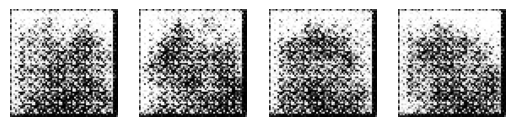

Epoch [2/50], Batch [50/94], D Loss: 1.7771, G Loss: 2.1223


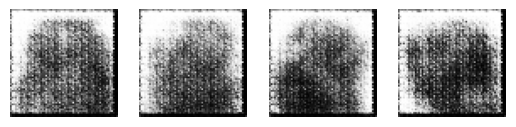

Epoch [3/50], Batch [50/94], D Loss: 1.1545, G Loss: 1.6704


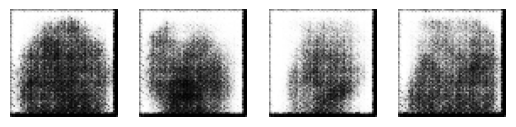

Epoch [4/50], Batch [50/94], D Loss: 0.9564, G Loss: 1.5558


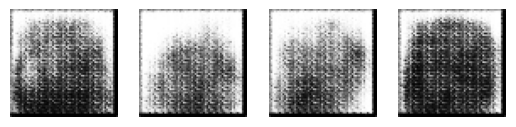

Epoch [5/50], Batch [50/94], D Loss: 0.7875, G Loss: 2.3413


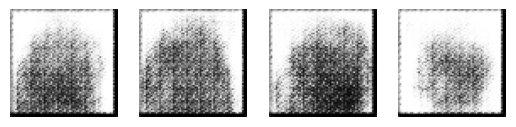

Epoch [6/50], Batch [50/94], D Loss: 1.0325, G Loss: 1.0875


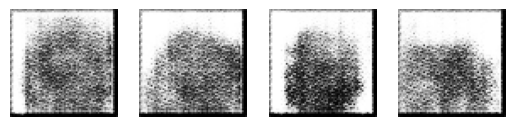

Epoch [7/50], Batch [50/94], D Loss: 0.8275, G Loss: 1.8692


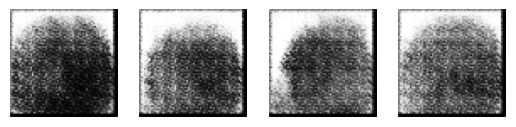

Epoch [8/50], Batch [50/94], D Loss: 0.6588, G Loss: 1.6295


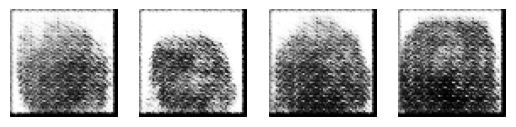

Epoch [9/50], Batch [50/94], D Loss: 1.3097, G Loss: 7.5807


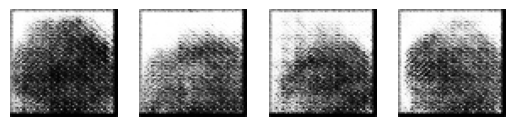

Epoch [10/50], Batch [50/94], D Loss: 0.3935, G Loss: 3.9701


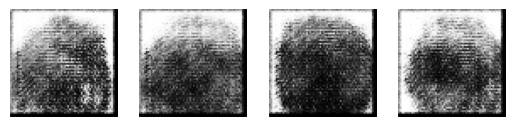

Epoch [11/50], Batch [50/94], D Loss: 0.2006, G Loss: 3.6054


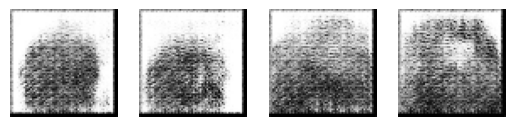

Epoch [12/50], Batch [50/94], D Loss: 0.2448, G Loss: 3.9474


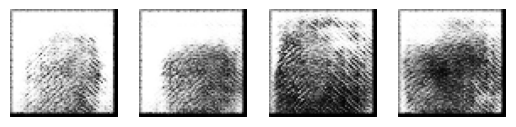

Epoch [13/50], Batch [50/94], D Loss: 0.2246, G Loss: 3.3951


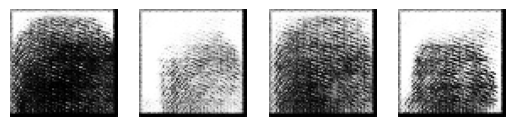

Epoch [14/50], Batch [50/94], D Loss: 0.1734, G Loss: 3.3470


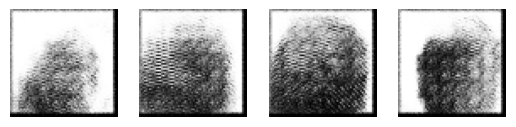

Epoch [15/50], Batch [50/94], D Loss: 0.1572, G Loss: 3.4933


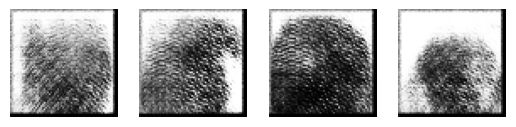

Epoch [16/50], Batch [50/94], D Loss: 0.2799, G Loss: 5.5794


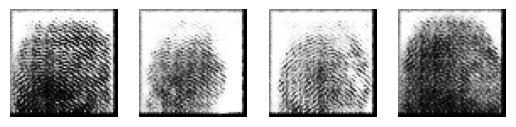

Epoch [17/50], Batch [50/94], D Loss: 0.2275, G Loss: 3.3695


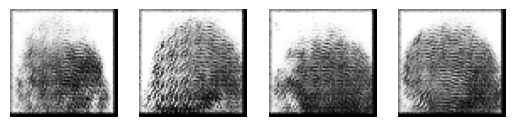

Epoch [18/50], Batch [50/94], D Loss: 0.1075, G Loss: 4.8081


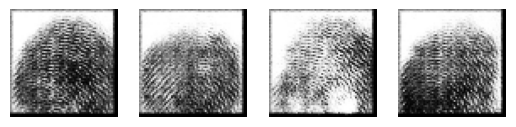

Epoch [19/50], Batch [50/94], D Loss: 0.0957, G Loss: 4.4509


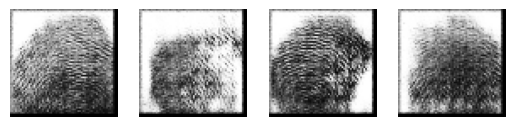

Epoch [20/50], Batch [50/94], D Loss: 1.6270, G Loss: 5.0879


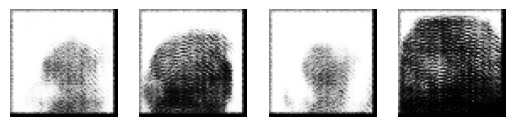

Epoch [21/50], Batch [50/94], D Loss: 0.1240, G Loss: 4.6623


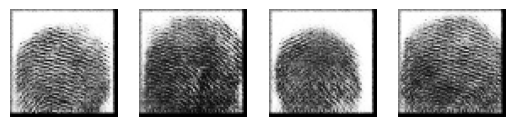

Epoch [22/50], Batch [50/94], D Loss: 0.1264, G Loss: 3.9813


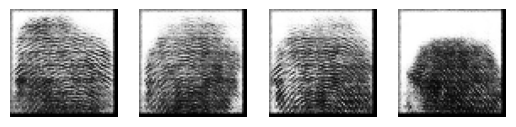

Epoch [23/50], Batch [50/94], D Loss: 0.1514, G Loss: 4.9668


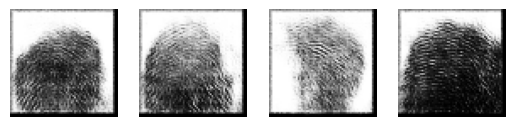

Epoch [24/50], Batch [50/94], D Loss: 0.2252, G Loss: 4.6398


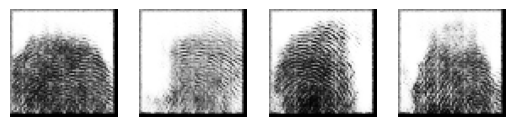

Epoch [25/50], Batch [50/94], D Loss: 0.5086, G Loss: 6.1839


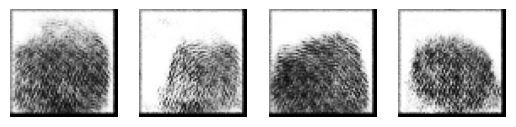

Epoch [26/50], Batch [50/94], D Loss: 0.1963, G Loss: 4.8972


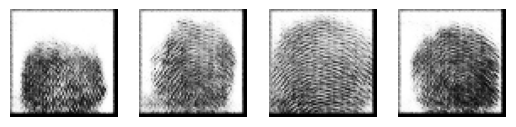

Epoch [27/50], Batch [50/94], D Loss: 0.1714, G Loss: 3.5250


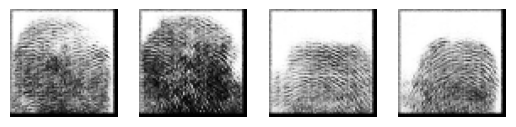

Epoch [28/50], Batch [50/94], D Loss: 2.1176, G Loss: 0.3522


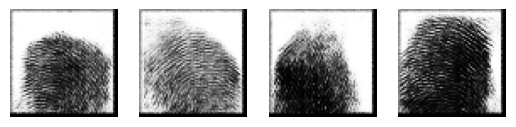

Epoch [29/50], Batch [50/94], D Loss: 0.1617, G Loss: 4.4340


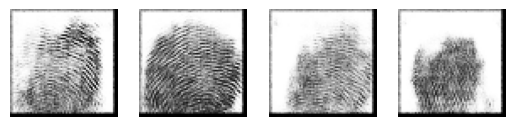

Epoch [30/50], Batch [50/94], D Loss: 0.0749, G Loss: 3.9655


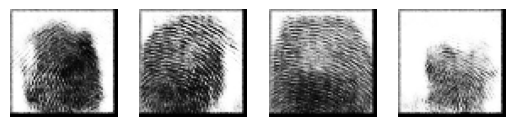

Epoch [31/50], Batch [50/94], D Loss: 0.1611, G Loss: 3.2462


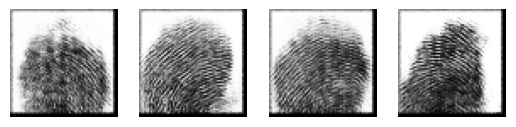

Epoch [32/50], Batch [50/94], D Loss: 0.2331, G Loss: 5.3637


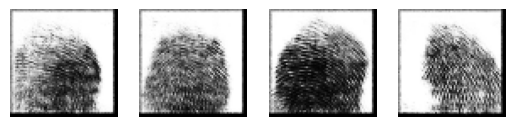

Epoch [33/50], Batch [50/94], D Loss: 0.0765, G Loss: 4.3678


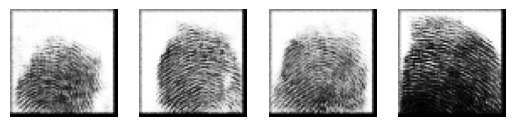

Epoch [34/50], Batch [50/94], D Loss: 0.1929, G Loss: 3.8786


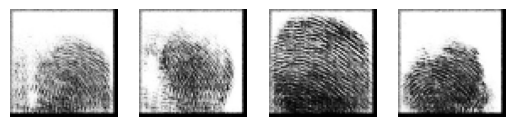

Epoch [35/50], Batch [50/94], D Loss: 0.1080, G Loss: 4.2077


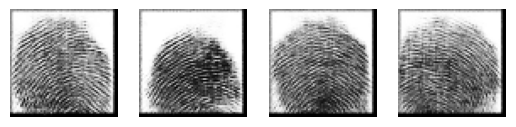

Epoch [36/50], Batch [50/94], D Loss: 0.0642, G Loss: 4.3860


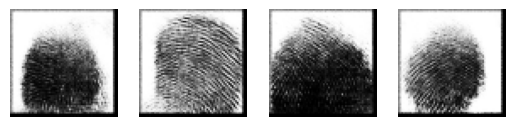

Epoch [37/50], Batch [50/94], D Loss: 0.1985, G Loss: 4.0626


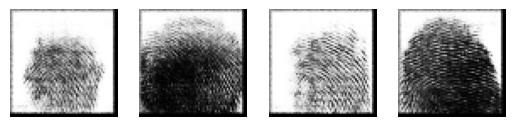

Epoch [38/50], Batch [50/94], D Loss: 0.0952, G Loss: 4.0936


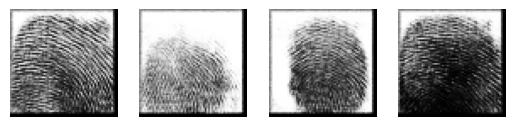

Epoch [39/50], Batch [50/94], D Loss: 0.0882, G Loss: 4.0246


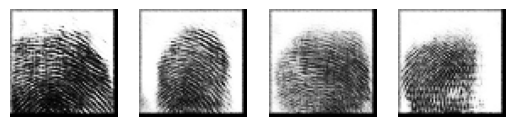

Epoch [40/50], Batch [50/94], D Loss: 0.1829, G Loss: 4.2774


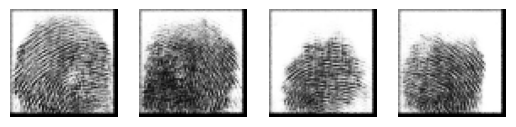

Epoch [41/50], Batch [50/94], D Loss: 0.1475, G Loss: 4.4101


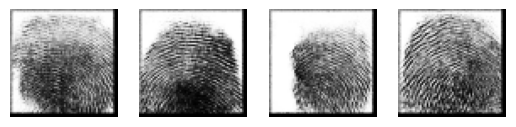

Epoch [42/50], Batch [50/94], D Loss: 0.0875, G Loss: 3.3200


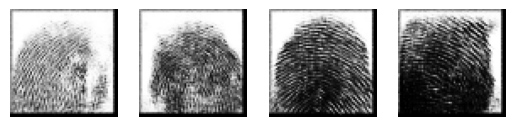

Epoch [43/50], Batch [50/94], D Loss: 0.6642, G Loss: 6.8034


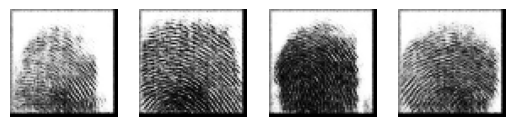

Epoch [44/50], Batch [50/94], D Loss: 0.0868, G Loss: 3.5341


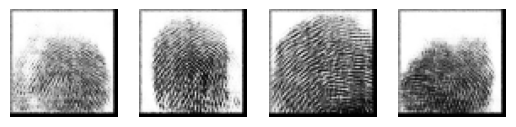

Epoch [45/50], Batch [50/94], D Loss: 0.0224, G Loss: 4.9011


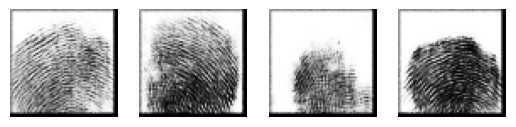

Epoch [46/50], Batch [50/94], D Loss: 0.0460, G Loss: 4.8356


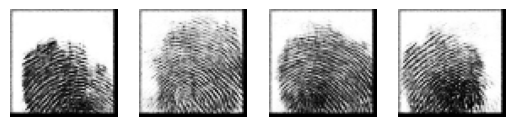

Epoch [47/50], Batch [50/94], D Loss: 0.0469, G Loss: 4.4216


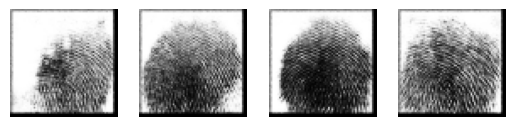

Epoch [48/50], Batch [50/94], D Loss: 0.0251, G Loss: 5.5470


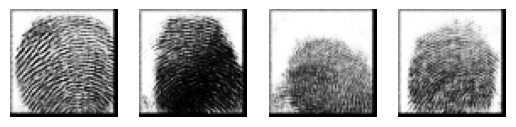

Epoch [49/50], Batch [50/94], D Loss: 0.0357, G Loss: 4.5090


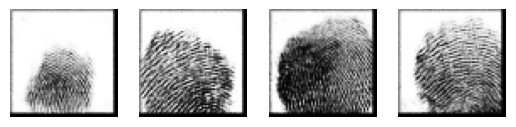

Epoch [50/50], Batch [50/94], D Loss: 0.0469, G Loss: 5.1454


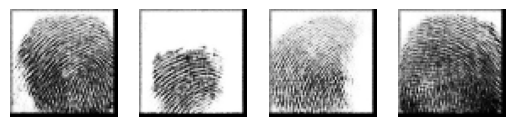

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class FingerprintGANDataset(Dataset):
    def __init__(self, df, data_path, transform=None):
        self.df = df
        self.data_path = data_path
        self.transform = transform
        self.finger2idx = {f:i for i,f in enumerate([
            "Left_thumb", "Left_index", "Left_middle", "Left_ring", "Left_little",
            "Right_thumb", "Right_index", "Right_middle", "Right_ring", "Right_little"
        ])}
        self.gender2idx = {"M":0, "F":1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_path, row['filename'])
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        image = image * 2 - 1  # normalize to [-1,1]
        finger_label = self.finger2idx[row['finger']]
        gender_label = self.gender2idx[row['gender']]
        return image, torch.tensor([finger_label, gender_label])


transform_gan = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
gan_dataset = FingerprintGANDataset(df, data_path, transform=transform_gan)
gan_loader = DataLoader(gan_dataset, batch_size=64, shuffle=True)

# ---------------- Generator ----------------
class Generator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=12):
        super().__init__()
        self.fc = nn.Linear(noise_dim + label_dim, 256*8*8)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)

    def forward(self, noise, labels):
        x = torch.cat([noise, labels], dim=1)
        x = F.relu(self.fc(x))
        x = x.view(-1, 256, 8, 8)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = torch.tanh(self.deconv3(x))
        return x

# ---------------- Discriminator ----------------
class Discriminator(nn.Module):
    def __init__(self, label_dim=12):
        super().__init__()
        self.conv1 = nn.Conv2d(1 + label_dim, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc = nn.Linear(256*8*8, 1)

    def forward(self, imgs, labels):
        batch_size = imgs.size(0)
        labels = labels.unsqueeze(2).unsqueeze(3)
        labels = labels.repeat(1,1,imgs.size(2), imgs.size(3))
        x = torch.cat([imgs, labels], dim=1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = x.view(batch_size, -1)
        x = torch.sigmoid(self.fc(x))
        return x

# ---------------- Hyperparameters ----------------
noise_dim = 100
num_fingers = 10
num_genders = 2
label_dim = num_fingers + num_genders
num_epochs = 50
lr = 0.0002
beta1 = 0.5

# ---------------- Initialize Models ----------------
G = Generator(noise_dim=noise_dim, label_dim=label_dim).to(device)
D = Discriminator(label_dim=label_dim).to(device)

optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

# ---------------- Training ----------------
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(gan_loader):
        batch_size_curr = real_images.size(0)
        real_images = real_images.to(device)
        finger_onehot = F.one_hot(labels[:,0].to(torch.int64), num_classes=num_fingers).float()
        gender_onehot = F.one_hot(labels[:,1].to(torch.int64), num_classes=num_genders).float()
        cond_labels = torch.cat([finger_onehot, gender_onehot], dim=1).to(device)

        # ---------------- Train Discriminator ----------------
        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        fake_images = G(noise, cond_labels).detach()
        real_labels_tensor = torch.ones(batch_size_curr,1).to(device)
        fake_labels_tensor = torch.zeros(batch_size_curr,1).to(device)

        optimizer_D.zero_grad()
        d_real_loss = criterion(D(real_images, cond_labels), real_labels_tensor)
        d_fake_loss = criterion(D(fake_images, cond_labels), fake_labels_tensor)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---------------- Train Generator ----------------
        noise = torch.randn(batch_size_curr, noise_dim).to(device)
        optimizer_G.zero_grad()
        gen_images = G(noise, cond_labels)
        g_loss = criterion(D(gen_images, cond_labels), real_labels_tensor)
        g_loss.backward()
        optimizer_G.step()

        # ---------------- Print and visualize ----------------
        if (i+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(gan_loader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

            for j in range(min(4, batch_size_curr)):
                plt.subplot(1,4,j+1)
                plt.imshow(gen_images[j].detach().cpu().squeeze(), cmap='gray')
                plt.axis('off')
            plt.show()


In [ ]:
torch.save(G.state_dict(), "/content/fingerprint_generator.pth")


In [ ]:
import os
import torch
import torchvision.transforms as T
from PIL import Image

# ---------------- Config ----------------
output_dir = "/content/synthetic_fingerprints"
os.makedirs(output_dir, exist_ok=True)

fingers = [
    "Left_thumb", "Left_index", "Left_middle", "Left_ring", "Left_little",
    "Right_thumb", "Right_index", "Right_middle", "Right_ring", "Right_little"
]

genders = {"M":0, "F":1}
num_fingers = len(fingers)
noise_dim = 100

# ---------------- Helper ----------------
def generate_one_fingerprint(generator, finger_idx, gender_idx):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(1, noise_dim).to(device)
        finger_onehot = torch.zeros(1, num_fingers).to(device)
        finger_onehot[0, finger_idx] = 1
        gender_onehot = torch.zeros(1, len(genders)).to(device)
        gender_onehot[0, gender_idx] = 1
        cond_label = torch.cat([finger_onehot, gender_onehot], dim=1)
        fake_img = generator(noise, cond_label)  # [-1,1]
        img = (fake_img.squeeze().cpu() + 1) * 127.5  # scale to [0,255]
        img = img.clamp(0,255).byte()
        return Image.fromarray(img.numpy())

# ---------------- Generate & Save ----------------
for gender_name, gender_idx in genders.items():
    for finger_idx, finger_name in enumerate(fingers):
        img = generate_one_fingerprint(G, finger_idx, gender_idx)
        filename = f"{gender_name}_{finger_name}.bmp"
        img.save(os.path.join(output_dir, filename))
        print(f"Saved: {filename}")


Saved: M_Left_thumb.bmp
Saved: M_Left_index.bmp
Saved: M_Left_middle.bmp
Saved: M_Left_ring.bmp
Saved: M_Left_little.bmp
Saved: M_Right_thumb.bmp
Saved: M_Right_index.bmp
Saved: M_Right_middle.bmp
Saved: M_Right_ring.bmp
Saved: M_Right_little.bmp
Saved: F_Left_thumb.bmp
Saved: F_Left_index.bmp
Saved: F_Left_middle.bmp
Saved: F_Left_ring.bmp
Saved: F_Left_little.bmp
Saved: F_Right_thumb.bmp
Saved: F_Right_index.bmp
Saved: F_Right_middle.bmp
Saved: F_Right_ring.bmp
Saved: F_Right_little.bmp


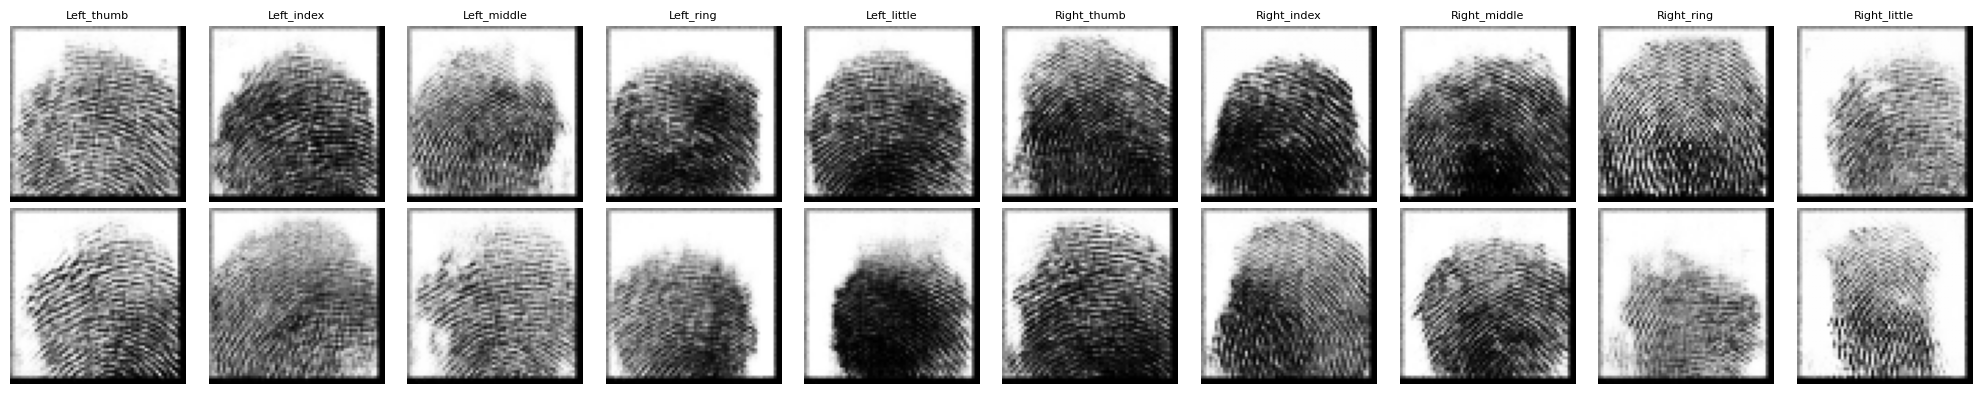

In [ ]:
import matplotlib.pyplot as plt

# ---------------- Generate and Display ----------------
G.eval()  # ensure generator is in eval mode

fig, axes = plt.subplots(2, 10, figsize=(20,4))  # 2 rows: M/F, 10 cols: fingers

for row_idx, (gender_name, gender_idx) in enumerate(genders.items()):
    for col_idx, finger_name in enumerate(fingers):
        with torch.no_grad():
            noise = torch.randn(1, noise_dim).to(device)
            finger_onehot = torch.zeros(1, num_fingers).to(device)
            finger_onehot[0, col_idx] = 1
            gender_onehot = torch.zeros(1, len(genders)).to(device)
            gender_onehot[0, gender_idx] = 1
            cond_label = torch.cat([finger_onehot, gender_onehot], dim=1)
            fake_img = G(noise, cond_label)
            img = (fake_img.squeeze().cpu() + 1) * 127.5
            img = img.clamp(0,255).byte().numpy()
            axes[row_idx, col_idx].imshow(img, cmap='gray')
            axes[row_idx, col_idx].axis('off')
            if row_idx == 0:
                axes[row_idx, col_idx].set_title(finger_name, fontsize=8)
    axes[row_idx,0].set_ylabel(gender_name, fontsize=12)

plt.tight_layout()
plt.show()
